Importing the required libraries
1.  **Chess** -> For board representation and move generation for a player
2. **IPython.display** -> For visualizing the board
3. **numpy** ->
4. **random** -> for generating random moves

In [7]:
import time
import chess
import chess.svg
from IPython.display import display, HTML, clear_output, SVG
import numpy as np
import pandas as pd 
import timeit
import random
import requests

# AI Chess Agent Project

## Helper functions

### Displays the chess board

In [8]:
def display_board(board, use_svg):
    if use_svg:
        return board._repr_svg_()
    else:
        return "<pre>" + str(board) + "</pre>"

### Checks if player agent is white or black

In [9]:
def who(agent):
    return "White" if agent == chess.WHITE else "Black"

### Obtains available moves

In [10]:
def get_move(prompt):
    uci = input(prompt)
    if uci and uci[0] == "q":
        raise KeyboardInterrupt()
    try:
        chess.Move.from_uci(uci)
    except:
        uci = None
    return uci

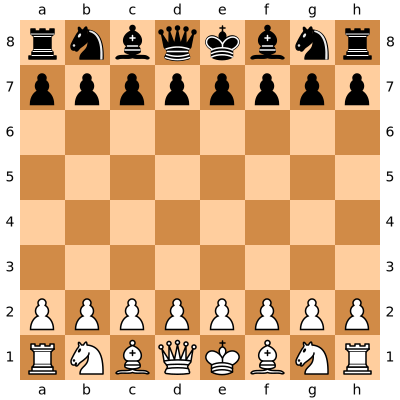

In [11]:
board = chess.Board()
SVG(chess.svg.board(board=board,size=400))  

### Tallies the white and black players pieces

In [12]:
def count_pieces(board):
    num_pieces = [0,0]
    
    num_pieces[0] += len(board.pieces(chess.PAWN,   chess.WHITE))
    num_pieces[0] += len(board.pieces(chess.BISHOP, chess.WHITE))
    num_pieces[0] += len(board.pieces(chess.KING,   chess.WHITE))
    num_pieces[0] += len(board.pieces(chess.QUEEN,  chess.WHITE))
    num_pieces[0] += len(board.pieces(chess.KNIGHT, chess.WHITE))
    num_pieces[0] += len(board.pieces(chess.ROOK,   chess.WHITE))

    num_pieces[1] += len(board.pieces(chess.PAWN,   chess.BLACK))
    num_pieces[1] += len(board.pieces(chess.BISHOP, chess.BLACK))
    num_pieces[1] += len(board.pieces(chess.KING,   chess.BLACK))
    num_pieces[1] += len(board.pieces(chess.QUEEN,  chess.BLACK))
    num_pieces[1] += len(board.pieces(chess.KNIGHT, chess.BLACK))
    num_pieces[1] += len(board.pieces(chess.ROOK,   chess.BLACK))
                             
    return num_pieces

### Plays a single game with two agent players

In [13]:
def play_game(agent1, agent2, visual="svg", pause=0.1):
    """
    agentN1, agent2: functions that takes board, return uci move
    visual: "simple" | "svg" | None
    """
    use_svg = (visual == "svg")
    board = chess.Board("8/4B3/8/8/5k2/8/8/1K5N w - - 0 1")
    try:
        while not board.is_game_over(claim_draw=True):
            if board.turn == chess.WHITE:
                uci = agent1(board)
            else:
                uci = agent2(board)
            name = who(board.turn)
            board.push_uci(uci)
            board_stop = display_board(board, use_svg)
            html = "<b>Move %s %s, Play '%s':</b><br/>%s" % (
                       len(board.move_stack), name, uci, board_stop)
            if visual is not None:
                if visual == "svg":
                    clear_output(wait=True)
                display(HTML(html))
                if visual == "svg":
                    time.sleep(pause)
    except KeyboardInterrupt:
        msg = "Game interrupted!"
        return (False, msg, board)
    game_has_winner = False
    if board.is_checkmate():
        msg = "checkmate: " + who(not board.turn) + " wins!"
        game_has_winner = not board.turn
    elif board.is_stalemate():
        msg = "draw: stalemate"
    elif board.is_fivefold_repetition():
        msg = "draw: 5-fold repetition"
    elif board.is_insufficient_material():
        msg = "draw: insufficient material"
    elif board.can_claim_draw():
        msg = "draw: claim"
    if visual is not None:
        print(msg)
    
    return (game_has_winner, msg, board)

### "Driver" allows for two agent players to play multiple games for a provided number of iterations. Returns a list of scores

In [14]:
def run(agent1, agent2, iterations, agent1_name, agent2_name):
#     df_scoreboard = pd.DataFrame(data={}, columns=['game_result','winner','moves_played', 'remaining_w_pieces','remaining_b_pieces'])    
    scores_list = list()
                                 
    for round_num in range(iterations):
        
        terminal_state = play_game(agent1, agent2, visual="svg", pause=0.00001)
#         time = timeit.timeit(play_game(agent1, agent2, visual="svg", pause=0), number=100)/100
        
        game_hase_winner = terminal_state[0]
        msg = terminal_state[1]
        moves_played = len(terminal_state[2].move_stack)
        remaining_w_pieces = count_pieces(terminal_state[2])[0]
        remaining_b_pieces = count_pieces(terminal_state[2])[1]

#         result_list = (game_hase_winner, msg, moves_played, count_pieces(result[2])[0], count_pieces(result[2])[1], result[3])
        result_list = (round_num + 1, iterations, agent1_name, agent2_name, game_hase_winner, msg, moves_played, remaining_w_pieces, remaining_b_pieces)
        scores_list.append(result_list)
        
    return scores_list

### Results Scoreboard

In [15]:
df = pd.DataFrame(columns=['round_num', 'iterations', 'agent1_name', 'agent2_name','game_has_winner','winner','moves_played', 'remain_w_pieces','remaining_b_pieces'])

## Random Agent Evaluation

### Plays two random agents against eachother 10 times

### Random Agent player

In [46]:
def random_agent(board):
    move = random.choice(list(board.legal_moves))
    return move.uci()

In [48]:
def endgame_eval(board):
    """ This evaluation function should be used when the number of 
    pieces on the board is less than or equal 7"""
    eval = 0
    query = "http://tablebase.lichess.ovh/standard?fen="
    fen = board.fen()
    request = query+fen.replace(" ","_")
    r = requests.get(request)
    if r.status_code == 429:
        time.sleep(1)
        print("waited for 1 s")
        request = query+fen.replace(" ","_")
        r = requests.get(request)
    print("response: ",r)
    wdl = r.json()["wdl"]
    if wdl is not None:
        if wdl<0:
            eval += 50
        if wdl>=0:
            eval -= 50
    return eval
def endgame_agent(board):
    moves = list(board.legal_moves)
    for move in moves:
        newboard = board.copy()
        # go through board and return a score
        move.score = endgame_eval(newboard)
    moves.sort(key=lambda move: move.score, reverse=True) # sort on score
    return moves[0].uci()

terminal_state = play_game(endgame_agent, random_agent, visual="svg", pause=0.1)

draw: claim


In [0]:
rand_eval_scores = run(random_agent, random_agent, 10, "random_agent", "random_agent")

draw: insufficient material


In [0]:
df_rand_eval_scoreboard = pd.DataFrame(data=rand_eval_scores, columns=['round_num', 'iterations', 'agent1_name', 'agent2_name','game_has_winner','winner','moves_played', 'remain_w_pieces','remaining_b_pieces'])

df_rand_eval_scoreboard.sort_values(by=['moves_played'], inplace=False, ascending=True)

,round_num,iterations,agent1_name,agent2_name,game_has_winner,winner,moves_played,remain_w_pieces,remaining_b_pieces
5,6,10,random_agent,random_agent,False,draw: insufficient material,239,2,1
4,5,10,random_agent,random_agent,False,draw: insufficient material,285,2,1
2,3,10,random_agent,random_agent,False,draw: insufficient material,297,2,1
9,10,10,random_agent,random_agent,False,draw: insufficient material,299,2,1
0,1,10,random_agent,random_agent,False,draw: insufficient material,335,1,1
8,9,10,random_agent,random_agent,False,draw: insufficient material,342,1,1
6,7,10,random_agent,random_agent,False,draw: claim,363,5,1
7,8,10,random_agent,random_agent,False,draw: insufficient material,367,1,1
1,2,10,random_agent,random_agent,False,draw: claim,384,1,2
3,4,10,random_agent,random_agent,False,draw: insufficient material,524,1,2


In [0]:
#update results scoreboard
df = df.append(df_rand_eval_scoreboard, ignore_index=True)

### Scoreboard

In [0]:
#10 best games by moves_played ascending
df.sort_values(by=['moves_played'], inplace=False, ascending=True).head(10)

,round_num,iterations,agent1_name,agent2_name,game_has_winner,winner,moves_played,remain_w_pieces,remaining_b_pieces
5,6,10,random_agent,random_agent,False,draw: insufficient material,239,2,1
4,5,10,random_agent,random_agent,False,draw: insufficient material,285,2,1
2,3,10,random_agent,random_agent,False,draw: insufficient material,297,2,1
9,10,10,random_agent,random_agent,False,draw: insufficient material,299,2,1
0,1,10,random_agent,random_agent,False,draw: insufficient material,335,1,1
8,9,10,random_agent,random_agent,False,draw: insufficient material,342,1,1
6,7,10,random_agent,random_agent,False,draw: claim,363,5,1
7,8,10,random_agent,random_agent,False,draw: insufficient material,367,1,1
1,2,10,random_agent,random_agent,False,draw: claim,384,1,2
3,4,10,random_agent,random_agent,False,draw: insufficient material,524,1,2


In [0]:
# #update results scoreboard
# df.append(df_rand_eval_scoreboard, ignore_index=True)

## Naive Agent Evaluation

### Naive evaluation function
Sets the score to 0 and assigns weights to every piece on the board. The weighted sum of all the available pieces on the board is then computed.

The white pieces are assigned positive values while the black ones are assigned negative values of the same magnitude. 

In [0]:
def naive_eval(board, move, my_color):
    score = 0
    ## Check some things about this move:
    score += 10 if board.is_capture(move) else 0
    # To actually make the move:
    board.push(move)
    # Now check some other things:
    for (piece, value) in [(chess.PAWN, 100), 
                           (chess.BISHOP, 330), 
                           (chess.KING, 0), 
                           (chess.QUEEN, 900), 
                           (chess.KNIGHT, 320),
                           (chess.ROOK, 500)]:
        score += len(board.pieces(piece, my_color)) * value
        score -= len(board.pieces(piece, not my_color)) * value
        # can also check things about the pieces position here
    return score

### Naive Agent
Chooses best score

In [0]:
def naive_agent(board):
    moves = list(board.legal_moves)
    for move in moves:
        newboard = board.copy()
        # go through board and return a score
        move.score = naive_eval(newboard, move, board.turn)
    moves.sort(key=lambda move: move.score, reverse=True) # sort on score
    return moves[0].uci()

In [0]:
result = play_game(naive_agent,random_agent, visual="svg", pause=0)

draw: claim


In [0]:
naive_eval_scores = run(naive_agent, random_agent, 10, "naive_agent", "random_agent")

draw: claim


In [0]:
# df_naive_eval_scoreboard = pd.DataFrame(data=naive_eval_scores, columns=['round_num', 'iterations', 'agent1_name', 'agent2_name','game_has_winner','winner','moves_played', 'remain_w_pieces','remaining_b_pieces'])
# df_naive_eval_scoreboard

df_naive_eval_scoreboard = pd.DataFrame(data=naive_eval_scores, columns=['round_num', 'iterations', 'agent1_name', 'agent2_name','game_has_winner','winner','moves_played', 'remain_w_pieces','remaining_b_pieces'])

df_naive_eval_scoreboard.sort_values(by=['moves_played'], inplace=False, ascending=True)


,round_num,iterations,agent1_name,agent2_name,game_has_winner,winner,moves_played,remain_w_pieces,remaining_b_pieces
4,5,10,naive_agent,random_agent,False,draw: claim,19,15,15
3,4,10,naive_agent,random_agent,False,draw: claim,55,15,2
7,8,10,naive_agent,random_agent,False,draw: claim,59,15,2
8,9,10,naive_agent,random_agent,False,draw: claim,59,14,2
0,1,10,naive_agent,random_agent,False,draw: claim,69,15,4
2,3,10,naive_agent,random_agent,False,draw: claim,71,15,1
5,6,10,naive_agent,random_agent,False,draw: claim,75,15,1
1,2,10,naive_agent,random_agent,False,draw: claim,81,12,1
9,10,10,naive_agent,random_agent,False,draw: claim,93,12,1
6,7,10,naive_agent,random_agent,False,draw: claim,100,14,1


In [0]:
# #update results scoreboard
# df.append(df_naive_eval_scoreboard, ignore_index=True)

#update results scoreboard
df = df.append(df_naive_eval_scoreboard, ignore_index=True)

### Scoreboard: Top 10 Games With Fewest Moves

In [0]:
#10 best games by moves_played ascending
df.sort_values(by=['moves_played'], inplace=False, ascending=True).head(10)

,round_num,iterations,agent1_name,agent2_name,game_has_winner,winner,moves_played,remain_w_pieces,remaining_b_pieces
5,6,10,random_agent,random_agent,False,draw: insufficient material,239,2,1
4,5,10,random_agent,random_agent,False,draw: insufficient material,285,2,1
2,3,10,random_agent,random_agent,False,draw: insufficient material,297,2,1
9,10,10,random_agent,random_agent,False,draw: insufficient material,299,2,1
0,1,10,random_agent,random_agent,False,draw: insufficient material,335,1,1
8,9,10,random_agent,random_agent,False,draw: insufficient material,342,1,1
6,7,10,random_agent,random_agent,False,draw: claim,363,5,1
7,8,10,random_agent,random_agent,False,draw: insufficient material,367,1,1
1,2,10,random_agent,random_agent,False,draw: claim,384,1,2
3,4,10,random_agent,random_agent,False,draw: insufficient material,524,1,2


### Naive Agent With Improved Evaluation

## Naive Random Heuristic Evaluation
Sets the score to a random value and assigns weights to every piece on the board. The weighted sum of all the available pieces on the board is then computed.

The white pieces are assigned positive values while the black ones are assigned negative values of the same magnitude. 

In [0]:
def naive_random_heuristic_eval(board, move, my_color):
    score = random.random()
    ## Check some things about this move:
    score += 10 if board.is_capture(move) else 0
    # To actually make the move:
    board.push(move)
    # Now check some other things:
    # for (piece, value) in [(chess.PAWN, 1), 
    #                        (chess.BISHOP, 4), 
    #                        (chess.KING, 0), 
    #                        (chess.QUEEN, 10), 
    #                        (chess.KNIGHT, 5),
    #                        (chess.ROOK, 3)]:
    for (piece, value) in [(chess.PAWN, 100), 
                        (chess.BISHOP, 330), 
                        (chess.KING, 0), 
                        (chess.QUEEN, 900), 
                        (chess.KNIGHT, 320),
                        (chess.ROOK, 500)]:
        score += len(board.pieces(piece, my_color)) * value
        score -= len(board.pieces(piece, not my_color)) * value
        # can also check things about the pieces position here
    # Check global things about the board
    score += 100 if board.is_checkmate() else 0
    return score

### Naive Agent with Random Heuristic Evaluator
Chooses best score

In [0]:
def naive_random_heuristic_agent(board):
    moves = list(board.legal_moves)
    for move in moves:
        newboard = board.copy()
        # go through board and return a score
        move.score = naive_random_heuristic_eval(newboard, move, board.turn)
    moves.sort(key=lambda move: move.score, reverse=True) # sort on score
    return moves[0].uci()

In [0]:
naive_rand_heuristic_eval_scores = run(naive_random_heuristic_agent, random_agent, 10, "naive_random_heuristic_agent", "random_agent")

checkmate: White wins!


In [0]:
# df_naive_rand_heuristic_eval_scoreboard = pd.DataFrame(data=naive_rand_heuristic_eval_scores, columns=['round_num', 'iterations', 'agent1_name', 'agent2_name','game_has_winner','winner','moves_played', 'remain_w_pieces','remaining_b_pieces'])
# df_naive_rand_heuristic_eval_scoreboard

df_naive_rand_heuristic_eval_scoreboard = pd.DataFrame(data=naive_rand_heuristic_eval_scores, columns=['round_num', 'iterations', 'agent1_name', 'agent2_name','game_has_winner','winner','moves_played', 'remain_w_pieces','remaining_b_pieces'])
df_naive_rand_heuristic_eval_scoreboard.sort_values(by=['moves_played'], inplace=False, ascending=True)

,round_num,iterations,agent1_name,agent2_name,game_has_winner,winner,moves_played,remain_w_pieces,remaining_b_pieces
8,9,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,5,16,16
2,3,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,7,16,16
7,8,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,53,14,1
5,6,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,57,15,1
0,1,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,79,10,2
1,2,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,95,11,1
3,4,10,naive_random_heuristic_agent,random_agent,False,draw: stalemate,109,13,1
6,7,10,naive_random_heuristic_agent,random_agent,False,draw: stalemate,109,12,1
9,10,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,209,10,1
4,5,10,naive_random_heuristic_agent,random_agent,False,draw: insufficient material,264,1,1


In [0]:
#update results scoreboard
df = df.append(df_naive_rand_heuristic_eval_scoreboard , ignore_index=True)

### Scoreboard: Top 10 Games With Fewest Moves

In [0]:
#10 best games by moves_played ascending
df.sort_values(by=['moves_played'], inplace=False, ascending=True).head(10)

,round_num,iterations,agent1_name,agent2_name,game_has_winner,winner,moves_played,remain_w_pieces,remaining_b_pieces
13,4,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,7,16,14
16,7,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,31,15,9
15,6,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,37,15,2
10,1,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,49,12,4
14,5,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,59,15,1
12,3,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,83,13,1
19,10,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,91,14,1
17,8,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,97,14,1
18,9,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,119,12,1
11,2,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,119,13,1


## Minimax

In [ ]:
board = chess.Board()
pieces = board.pieces(chess.PAWN, chess.WHITE)
print("pawn pieces: ",pieces)
print("len: ",len(pieces))
for i in pieces:
  print("i: ",i)
for i in pieces:
  print("mirror_i: ",chess.square_mirror(i))

In [0]:
Piece-square tables

pawn pieces:  . . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
1 1 1 1 1 1 1 1
. . . . . . . .
len:  8
i:  8
i:  9
i:  10
i:  11
i:  12
i:  13
i:  14
i:  15
mirror_i:  48
mirror_i:  49
mirror_i:  50
mirror_i:  51
mirror_i:  52
mirror_i:  53
mirror_i:  54
mirror_i:  55


NameError: ignored

Piece-square tables

In [0]:
pawntable = [
 0,  0,  0,  0,  0,  0,  0,  0,
 5, 10, 10,-20,-20, 10, 10,  5,
 5, -5,-10,  0,  0,-10, -5,  5,
 0,  0,  0, 20, 20,  0,  0,  0,
 5,  5, 10, 25, 25, 10,  5,  5,
10, 10, 20, 30, 30, 20, 10, 10,
50, 50, 50, 50, 50, 50, 50, 50,
 0,  0,  0,  0,  0,  0,  0,  0]

knightstable = [
-50,-40,-30,-30,-30,-30,-40,-50,
-40,-20,  0,  5,  5,  0,-20,-40,
-30,  5, 10, 15, 15, 10,  5,-30,
-30,  0, 15, 20, 20, 15,  0,-30,
-30,  5, 15, 20, 20, 15,  5,-30,
-30,  0, 10, 15, 15, 10,  0,-30,
-40,-20,  0,  0,  0,  0,-20,-40,
-50,-40,-30,-30,-30,-30,-40,-50]

bishopstable = [
-20,-10,-10,-10,-10,-10,-10,-20,
-10,  5,  0,  0,  0,  0,  5,-10,
-10, 10, 10, 10, 10, 10, 10,-10,
-10,  0, 10, 10, 10, 10,  0,-10,
-10,  5,  5, 10, 10,  5,  5,-10,
-10,  0,  5, 10, 10,  5,  0,-10,
-10,  0,  0,  0,  0,  0,  0,-10,
-20,-10,-10,-10,-10,-10,-10,-20]

rookstable = [
  0,  0,  0,  5,  5,  0,  0,  0,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
  5, 10, 10, 10, 10, 10, 10,  5,
 0,  0,  0,  0,  0,  0,  0,  0]

queenstable = [
-20,-10,-10, -5, -5,-10,-10,-20,
-10,  0,  0,  0,  0,  0,  0,-10,
-10,  5,  5,  5,  5,  5,  0,-10,
  0,  0,  5,  5,  5,  5,  0, -5,
 -5,  0,  5,  5,  5,  5,  0, -5,
-10,  0,  5,  5,  5,  5,  0,-10,
-10,  0,  0,  0,  0,  0,  0,-10,
-20,-10,-10, -5, -5,-10,-10,-20]

kingstable = [
 20, 30, 10,  0,  0, 10, 30, 20,
 20, 20,  0,  0,  0,  0, 20, 20,
-10,-20,-20,-20,-20,-20,-20,-10,
-20,-30,-30,-40,-40,-30,-30,-20,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30]

## minimax evaluation
Picks the best move for the white side with the help of the mini-max algorithm and alpha-beta pruning.

In [0]:
def evaluateMoves(board):
    if board.is_checkmate():
      if board.turn:
          return -9999
      else:
          return 9999
    if board.is_stalemate():
        return 0
    if board.is_insufficient_material():
        return 0
    
    wp = len(board.pieces(chess.PAWN, chess.WHITE))
    bp = len(board.pieces(chess.PAWN, chess.BLACK))
    wn = len(board.pieces(chess.KNIGHT, chess.WHITE))
    bn = len(board.pieces(chess.KNIGHT, chess.BLACK))
    wb = len(board.pieces(chess.BISHOP, chess.WHITE))
    bb = len(board.pieces(chess.BISHOP, chess.BLACK))
    wr = len(board.pieces(chess.ROOK, chess.WHITE))
    br = len(board.pieces(chess.ROOK, chess.BLACK))
    wq = len(board.pieces(chess.QUEEN, chess.WHITE))
    bq = len(board.pieces(chess.QUEEN, chess.BLACK))
    
    material = 100*(wp-bp)+320*(wn-bn)+330*(wb-bb)+500*(wr-br)+900*(wq-bq)
    
    pawnsq = sum([pawntable[i] for i in board.pieces(chess.PAWN, chess.WHITE)])
    pawnsq= pawnsq + sum([-pawntable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.PAWN, chess.BLACK)])
    knightsq = sum([knightstable[i] for i in board.pieces(chess.KNIGHT, chess.WHITE)])
    knightsq = knightsq + sum([-knightstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.KNIGHT, chess.BLACK)])
    bishopsq= sum([bishopstable[i] for i in board.pieces(chess.BISHOP, chess.WHITE)])
    bishopsq= bishopsq + sum([-bishopstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.BISHOP, chess.BLACK)])
    rooksq = sum([rookstable[i] for i in board.pieces(chess.ROOK, chess.WHITE)]) 
    rooksq = rooksq + sum([-rookstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.ROOK, chess.BLACK)])
    queensq = sum([queenstable[i] for i in board.pieces(chess.QUEEN, chess.WHITE)]) 
    queensq = queensq + sum([-queenstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.QUEEN, chess.BLACK)])
    kingsq = sum([kingstable[i] for i in board.pieces(chess.KING, chess.WHITE)]) 
    kingsq = kingsq + sum([-kingstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.KING, chess.BLACK)])
    
    eval = material + pawnsq + knightsq + bishopsq+ rooksq+ queensq + kingsq
    return eval
    # if board.turn:
    #     return eval
    # else:
    #     return -eval

In [0]:
def maxValue(board, currentAgent, depth,alpha,beta):
    bestMove = -9999

    moves = list(board.legal_moves)
    for move in moves:
        newboard = board.copy()
        newboard.push_uci(move.uci()) 
        bestMove = max(bestMove,miniMaxDecision(newboard, not currentAgent , depth -1,alpha,beta))
        if bestMove >=beta :
          return bestMove
        alpha = max(alpha, bestMove)
    return bestMove


In [0]:
def minValue(board, currentAgent, depth,alpha,beta):
    bestMove = 9999
    moves = list(board.legal_moves)

    for move in moves:
        newboard = board.copy()
        newboard.push_uci(move.uci()) 
        bestMove = min(bestMove,miniMaxDecision(newboard, not currentAgent, depth -1,alpha,beta))
        if bestMove <= alpha:
          return bestMove
        beta = min(beta, bestMove)
    return bestMove

In [0]:
def miniMaxDecision(board, currentAgent, depth,alpha,beta):
    if depth == 0 :
        return evaluateMoves(board)

    if currentAgent:
        return maxValue(board, currentAgent, depth, alpha, beta)
    else:
        return minValue(board, currentAgent, depth, alpha, beta)

In [0]:
def mini_max_agent(board):
    moves = list(board.legal_moves)
    for move in moves:
        newboard = board.copy()
        newboard.push_uci(move.uci())
        move.score = miniMaxDecision(newboard, False , 2, -10000,10000)
    moves.sort(key=lambda move: move.score, reverse=True) # sort on score
    return moves[0].uci()

In [0]:
play_game(mini_max_agent, naive_random_heuristic_agent)

checkmate: White wins!


(True,
 'checkmate: White wins!',
 Board('4k3/p1p1Q3/n7/1p1Np1pp/3N4/8/P2PPPPP/R3KB1R b Q - 4 23'))

In [0]:
minimax_eval_scores = run(mini_max_agent, naive_random_heuristic_agent, 10, "mini_max_agent", "naive_random_agent")

checkmate: White wins!


In [0]:
df_minimax_eval_scoreboard = pd.DataFrame(data=minimax_eval_scores, columns=['round_num', 'iterations', 'agent1_name', 'agent2_name','game_has_winner','winner','moves_played', 'remain_w_pieces','remaining_b_pieces'])

df_minimax_eval_scoreboard.sort_values(by=['moves_played'], inplace=False, ascending=True)

,round_num,iterations,agent1_name,agent2_name,game_has_winner,winner,moves_played,remain_w_pieces,remaining_b_pieces
0,1,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,15,16,14
3,4,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,21,13,11
5,6,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,21,13,12
8,9,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,25,14,10
4,5,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,31,12,9
9,10,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,39,11,8
7,8,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,45,12,4
1,2,10,mini_max_agent,naive_random_agent,False,draw: stalemate,59,13,3
2,3,10,mini_max_agent,naive_random_agent,False,draw: stalemate,61,9,1
6,7,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,61,12,6


In [0]:
#update results scoreboard
df = df.append(df_minimax_eval_scoreboard, ignore_index=True)

### Scoreboard: Top 10 Games With Fewest Moves

In [0]:
#10 best games by moves_played ascending
df.sort_values(by=['moves_played'], inplace=False, ascending=True).head(10)

,round_num,iterations,agent1_name,agent2_name,game_has_winner,winner,moves_played,remain_w_pieces,remaining_b_pieces
13,4,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,7,16,14
22,3,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,21,13,12
31,2,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,23,16,14
20,1,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,29,15,10
34,5,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,29,13,10
16,7,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,31,15,9
29,10,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,33,12,10
15,6,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,37,15,2
39,10,10,mini_max_agent,naive_random_agent,False,draw: claim,38,14,12
24,5,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,39,13,5


### Games Where Player 1 (white) Wins, Ordered by Moves Played Desc

In [0]:
# d2 = df.loc[df['winner'] == 'checkmate: White wins!']

df.sort_values(by=['winner','moves_played'], inplace=False, ascending=True).head(10)

,round_num,iterations,agent1_name,agent2_name,game_has_winner,winner,moves_played,remain_w_pieces,remaining_b_pieces
13,4,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,7,16,14
22,3,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,21,13,12
20,1,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,29,15,10
16,7,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,31,15,9
29,10,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,33,12,10
15,6,10,naive_random_heuristic_agent,random_agent,True,checkmate: White wins!,37,15,2
24,5,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,39,13,5
26,7,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,41,13,6
28,9,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,45,14,10
23,4,10,mini_max_agent,naive_random_agent,True,checkmate: White wins!,47,15,11


In [0]:
# d2.sort_values(by=['moves_played'], inplace=False, ascending=True)

NameError: ignored